<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode005.cluster


In [2]:
!nvidia-smi

Sat Jun 22 10:06:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:17:00.0 Off |                    0 |
| N/A   36C    P0             39W /  250W |       1MiB /  40960MiB |      5%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool, cpu_count
import os
import psutil

###### Parameters 
mag = 1            # Magnitude of the coupling
beta = 1           # Inverse temperature 
alpha = 1            
gamma = 1          # Anharmonic potential U(x) = alpha/2 * x^2 + gamma/4 * x^4
N = 100            # Total number of oscillators in the chain 
dt = 0.01 
delta_t = 0.5
batch = 400
minibatch = 1
sec_length = 400

Time = 5 * delta_t * sec_length
length = int(Time / dt) + 1
t = np.linspace(0, Time, length) # Define time axis
gap = int(delta_t / dt)
t_store = t[0:-1:gap]

# (q25,q75)
q25_store = np.zeros([t_store.size + 1, batch])    
q75_store = np.zeros([t_store.size + 1, batch])

In [8]:
def solve_sde(batch_idx):
    np.random.seed((batch_idx+1)*100)
    name = multiprocessing.current_process().name        
    print(f'>>>>>>>===============================================\n{name} starting. \nparent process:{os.getppid()}------process id:{os.getpid()}\n===============================================>>>>>>>\n')    
    
    p0 = np.zeros((N, minibatch))
    q0 = np.zeros((N, minibatch))
    p1 = np.zeros((N, minibatch))
    q1 = np.zeros((N, minibatch))

    local_q25_store = np.zeros([t_store.size + 1, minibatch])    
    local_q75_store = np.zeros([t_store.size + 1, minibatch])

    j = 1
    for i in range(1, length):
        q1 = q0 + dt * (p0 - np.roll(p0, 1, axis=0))
        p1 = (1 - mag * dt) * p0 + dt * alpha * (np.roll(q0, -1, axis=0) - q0) + \
             dt * gamma * (np.roll(q0, -1, axis=0)**3 - q0**3) + \
             np.sqrt(2 * dt * gamma / beta) * np.random.randn(N, minibatch)
        if i % gap == 0:
            local_q25_store[j,:] = np.sum(q1[0:25,:], axis=0)
            local_q75_store[j,:] = np.sum(q1[0:75,:], axis=0)
            j += 1
        p0 = p1
        q0 = q1
    
    print(f"Batch {batch_idx} completed. \n")
    return batch_idx, local_q25_store, local_q75_store

In [9]:
if __name__ == '__main__':
    start = time.time()
    test_batch = int(batch / minibatch)
    num_cores = min(cpu_count(), test_batch)
    with Pool(num_cores) as pool:
        results = pool.map(solve_sde, range(test_batch))
    pool.close()
    pool.join()
    
    end = time.time()
    
    print(f'total runtime: {end-start}')

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:35086------process id:35235
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:35086------process id:35237
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:35086------process id:35236
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:35086------process id:35238
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:35086------process id:35239
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent proce


>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:35086------process id:35283
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:35086------process id:35282
===============================================>>>>>>>






>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:35086------process id:35285
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:35086------process id:35284
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:35086------process id:35286
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-53 starting. 

>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:35086------process id:35254
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:35086------process id:35263
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:35086------process id:35288
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:35086------process id:35237
===============================================>>>>>>>




>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:35086------process id:35242
===============================================>>>>>>>


Batch 100 completed. 

Batch 42 completed. 
Batch 92 completed. 


>>>>>>>===========

Batch 65 completed. 
>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:35086------process id:35253
===============================================>>>>>>>


Batch 5 completed. 

>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:35086------process id:35261
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:35086------process id:35250
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:35086------process id:35242
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:35086------process id:35247
===============================================>>>>>>>

>>>>>>>=======================================



>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:35086------process id:35276
===============================================>>>>>>>

Batch 126 completed. 

>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:35086------process id:35249
===============================================>>>>>>>

Batch 114 completed. 
Batch 118 completed. 


>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:35086------process id:35275
===============================================>>>>>>>
Batch 130 completed. 


>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:35086------process id:35243
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:35086------process id:35273
===============================================>>

>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:35086------process id:35286
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:35086------process id:35256
===============================================>>>>>>>


Batch 162 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:35086------process id:35266
===============================================>>>>>>>


Batch 198 completed. 

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:35086------process id:35251
===============================================>>>>>>>

Batch 208 completed. 

Batch 202 completed. 
>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:35086------process id:35277
===============================================>



>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:35086------process id:35245
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:35086------process id:35254
===============================================>>>>>>>


Batch 193 completed. 
Batch 197 completed. 


Batch 183 completed. 
Batch 115 completed. 


Batch 123 completed. 
>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:35086------process id:35285
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:35086------process id:35244
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:35086------process id:35253
========================

Batch 240 completed. 


>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:35086------process id:35273
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:35086------process id:35250
===============================================>>>>>>>


Batch 242 completed. 
Batch 256 completed. 


>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:35086------process id:35255
===============================================>>>>>>>

Batch 250 completed. 

Batch 254 completed. 
>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:35086------process id:35271
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:35086------process id:35267
===========================


Batch 322 completed. 

>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:35086------process id:35287
===============================================>>>>>>>

Batch 324 completed. 

>>>>>>>===============================================
ForkPoolWorker-26 starting. 
parent process:35086------process id:35260
===============================================>>>>>>>

Batch 320 completed. 

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:35086------process id:35282
===============================================>>>>>>>

Batch 326 completed. 

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:35086------process id:35235
===============================================>>>>>>>

Batch 328 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:35086------process id:35290
==========================


Batch 285 completed. 


Batch 295 completed. 

Batch 299 completed. 

Batch 301 completed. 

Batch 303 completed. 

Batch 309 completed. 
Batch 305 completed. 


Batch 293 completed. 

Batch 313 completed. 

Batch 311 completed. 

Batch 319 completed. 

Batch 315 completed. 
Batch 325 completed. 


Batch 323 completed. 

Batch 317 completed. 

Batch 307 completed. 

Batch 321 completed. 

Batch 327 completed. 

Batch 329 completed. 

Batch 331 completed. 

Batch 333 completed. 

Batch 335 completed. 

Batch 336 completed. 

>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:35086------process id:35275
===============================================>>>>>>>

Batch 338 completed. 

Batch 342 completed. 
>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:35086------process id:35246
===============================================>>>>>>>


>>>>>>>===============================================
Fo

Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

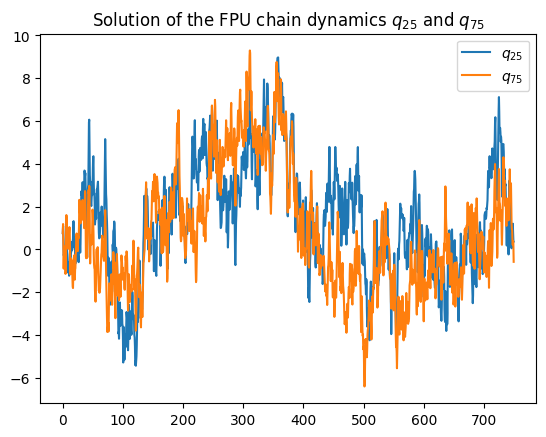

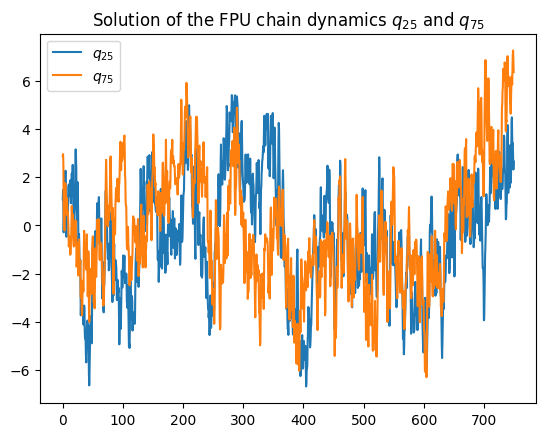

In [10]:
for i, local_q25_store, local_q75_store in results:
        q25_store[:, i*minibatch:(i+1)*minibatch] = local_q25_store
        q75_store[:, i*minibatch:(i+1)*minibatch] = local_q75_store

Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


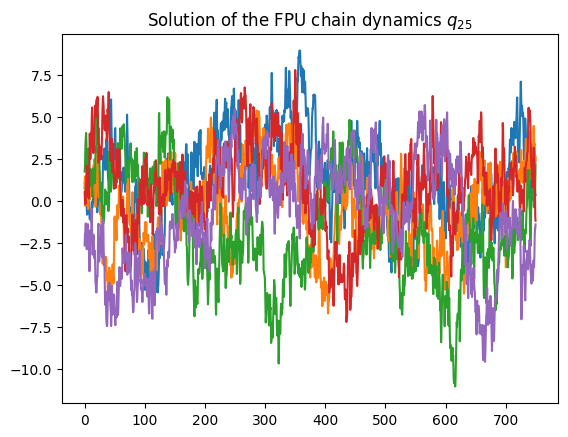

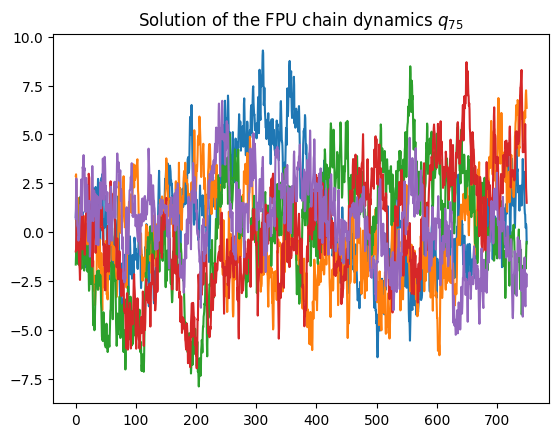

In [11]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [12]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [13]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [14]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


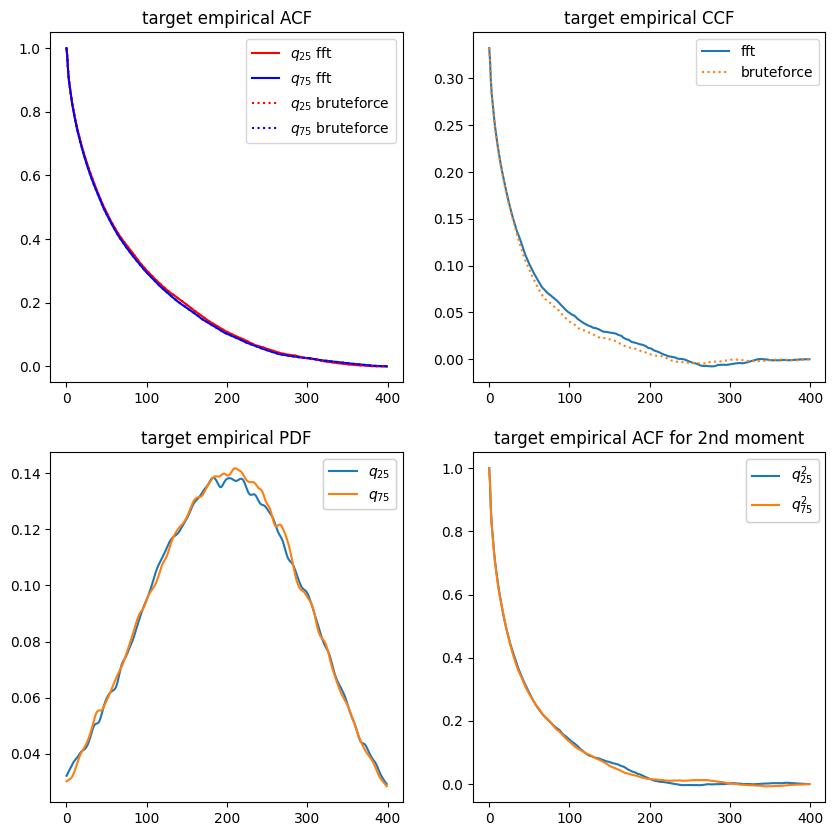

In [15]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

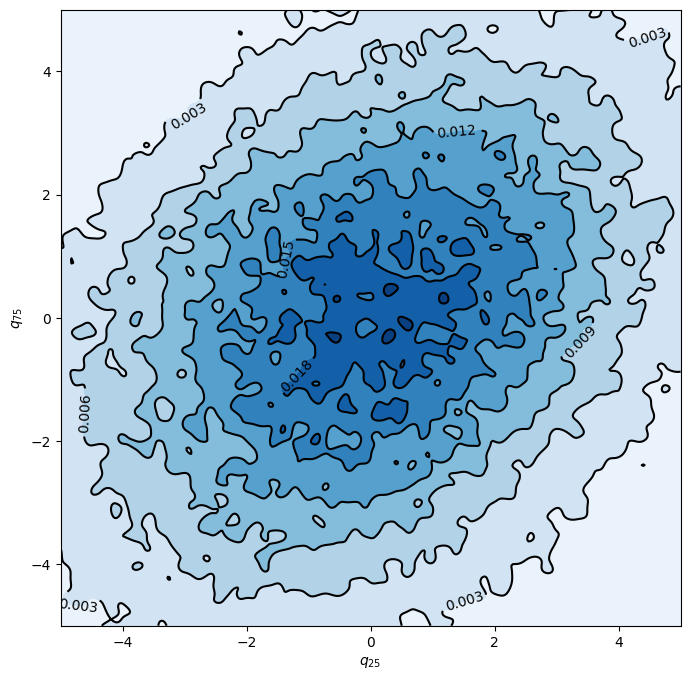

In [16]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

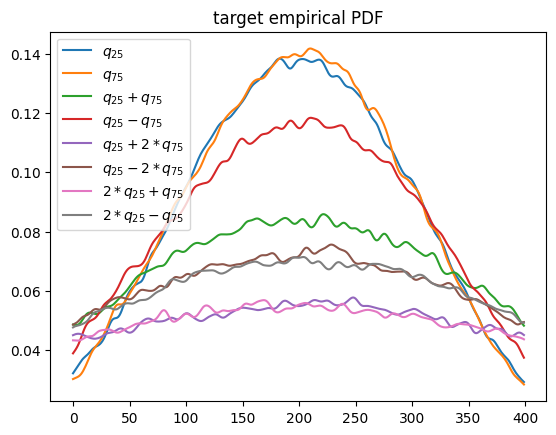

In [17]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [18]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.arch.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.arch.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.arch.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.arch.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [19]:
model_type = 1

In [20]:
### Defining SINN model
net = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.7025, 0.6869, acf: 0.07541, ccf: 0.00452, pdf: 0.28796, pdf2: 0.28602, acf2: 0.03294
[50]-th step loss: 0.0537, 0.0502, acf: 0.01190, ccf: 0.02176, pdf: 0.01022, pdf2: 0.00518, acf2: 0.00118
[100]-th step loss: 0.0205, 0.0237, acf: 0.00816, ccf: 0.00626, pdf: 0.00318, pdf2: 0.00151, acf2: 0.00458
[150]-th step loss: 0.0119, 0.0143, acf: 0.00543, ccf: 0.00370, pdf: 0.00270, pdf2: 0.00075, acf2: 0.00172
[200]-th step loss: 0.0083, 0.0080, acf: 0.00346, ccf: 0.00070, pdf: 0.00201, pdf2: 0.00099, acf2: 0.00087
[250]-th step loss: 0.0260, 0.0301, acf: 0.01484, ccf: 0.00322, pdf: 0.00636, pdf2: 0.00294, acf2: 0.00271
[300]-th step loss: 0.0177, 0.0165, acf: 0.00631, ccf: 0.00131, pdf: 0.00672, pdf2: 0.00167, acf2: 0.00048
[350]-th step loss: 0.0109, 0.0102, acf: 0.00266, ccf: 0.00019, pdf: 0.00433, pdf2: 0.00164, acf2: 0.00136
[400]-th step loss: 0.0089, 0.0101, acf: 0.00315, ccf: 0.00074, pdf: 0.00399, pdf2: 0.00154, acf2: 0.00065
[450]-th step loss: 0.0114, 0.0081, acf:

[3850]-th step loss: 0.0119, 0.0121, acf: 0.00409, ccf: 0.00023, pdf: 0.00561, pdf2: 0.00195, acf2: 0.00019
[3900]-th step loss: 0.0124, 0.0122, acf: 0.00403, ccf: 0.00052, pdf: 0.00558, pdf2: 0.00195, acf2: 0.00013
[3950]-th step loss: 0.0135, 0.0136, acf: 0.00604, ccf: 0.00011, pdf: 0.00520, pdf2: 0.00215, acf2: 0.00011
[4000]-th step loss: 0.0126, 0.0128, acf: 0.00508, ccf: 0.00008, pdf: 0.00552, pdf2: 0.00198, acf2: 0.00010
[4050]-th step loss: 0.0130, 0.0125, acf: 0.00491, ccf: 0.00013, pdf: 0.00543, pdf2: 0.00197, acf2: 0.00009
[4100]-th step loss: 0.0134, 0.0137, acf: 0.00540, ccf: 0.00034, pdf: 0.00594, pdf2: 0.00193, acf2: 0.00011
[4150]-th step loss: 0.0129, 0.0123, acf: 0.00461, ccf: 0.00012, pdf: 0.00548, pdf2: 0.00195, acf2: 0.00011
[4200]-th step loss: 0.0130, 0.0122, acf: 0.00409, ccf: 0.00020, pdf: 0.00584, pdf2: 0.00187, acf2: 0.00019
[4250]-th step loss: 0.0136, 0.0138, acf: 0.00578, ccf: 0.00025, pdf: 0.00568, pdf2: 0.00199, acf2: 0.00010
[4300]-th step loss: 0.0120,

[7650]-th step loss: 0.1252, 0.1249, acf: 0.08150, ccf: 0.00582, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03756
[7700]-th step loss: 0.1254, 0.1248, acf: 0.08148, ccf: 0.00579, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03754
[7750]-th step loss: 0.1253, 0.1248, acf: 0.08146, ccf: 0.00578, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03754
[7800]-th step loss: 0.1246, 0.1247, acf: 0.08143, ccf: 0.00576, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03751
[7850]-th step loss: 0.1246, 0.1247, acf: 0.08143, ccf: 0.00575, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03750
[7900]-th step loss: 0.1246, 0.1246, acf: 0.08139, ccf: 0.00572, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03750
[7950]-th step loss: 0.1248, 0.1246, acf: 0.08137, ccf: 0.00573, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03748
[8000]-th step loss: 0.1249, 0.1246, acf: 0.08136, ccf: 0.00571, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03749
[8050]-th step loss: 0.1247, 0.1245, acf: 0.08131, ccf: 0.00568, pdf: 0.00001, pdf2: 0.00001, acf2: 0.03746
[8100]-th step loss: 0.1245,

[11450]-th step loss: 0.1235, 0.1233, acf: 0.08082, ccf: 0.00523, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03724
[11500]-th step loss: 0.1236, 0.1232, acf: 0.08079, ccf: 0.00522, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03722
[11550]-th step loss: 0.1232, 0.1232, acf: 0.08077, ccf: 0.00521, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03721
[11600]-th step loss: 0.1235, 0.1232, acf: 0.08080, ccf: 0.00522, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03722
[11650]-th step loss: 0.1236, 0.1232, acf: 0.08077, ccf: 0.00519, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03720
[11700]-th step loss: 0.1235, 0.1232, acf: 0.08077, ccf: 0.00520, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03721
[11750]-th step loss: 0.1238, 0.1232, acf: 0.08075, ccf: 0.00519, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03721
[11800]-th step loss: 0.1238, 0.1232, acf: 0.08078, ccf: 0.00519, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03722
[11850]-th step loss: 0.1230, 0.1231, acf: 0.08074, ccf: 0.00517, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03721
[11900]-th step los

[15250]-th step loss: 0.1225, 0.1222, acf: 0.08022, ccf: 0.00486, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03713
[15300]-th step loss: 0.1226, 0.1222, acf: 0.08021, ccf: 0.00485, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03713
[15350]-th step loss: 0.1230, 0.1221, acf: 0.08016, ccf: 0.00483, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03712
[15400]-th step loss: 0.1223, 0.1222, acf: 0.08019, ccf: 0.00485, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03714
[15450]-th step loss: 0.1224, 0.1222, acf: 0.08021, ccf: 0.00485, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03713
[15500]-th step loss: 0.1223, 0.1221, acf: 0.08018, ccf: 0.00484, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03712
[15550]-th step loss: 0.1225, 0.1221, acf: 0.08015, ccf: 0.00483, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03713
[15600]-th step loss: 0.1223, 0.1222, acf: 0.08017, ccf: 0.00483, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03714
[15650]-th step loss: 0.1221, 0.1222, acf: 0.08020, ccf: 0.00484, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03712
[15700]-th step los

[19050]-th step loss: 0.1220, 0.1217, acf: 0.07985, ccf: 0.00468, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03712
[19100]-th step loss: 0.1215, 0.1216, acf: 0.07982, ccf: 0.00468, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03711
[19150]-th step loss: 0.1221, 0.1216, acf: 0.07981, ccf: 0.00467, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03709
[19200]-th step loss: 0.1218, 0.1216, acf: 0.07983, ccf: 0.00467, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03710
[19250]-th step loss: 0.1219, 0.1216, acf: 0.07982, ccf: 0.00467, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03711
[19300]-th step loss: 0.1219, 0.1215, acf: 0.07979, ccf: 0.00466, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03709
[19350]-th step loss: 0.1223, 0.1216, acf: 0.07983, ccf: 0.00467, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03711
[19400]-th step loss: 0.1212, 0.1215, acf: 0.07979, ccf: 0.00466, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03708
[19450]-th step loss: 0.1218, 0.1215, acf: 0.07977, ccf: 0.00466, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03710
[19500]-th step los

In [21]:
net.arch.input_size

2

In [22]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Iteration $n$',fontsize=15)
    plt.ylabel(r'$L_2$ Loss',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [23]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [24]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [25]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

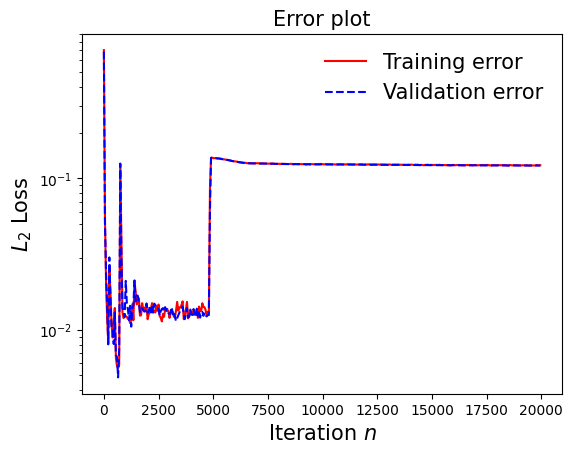

In [26]:
draw_loss(model)

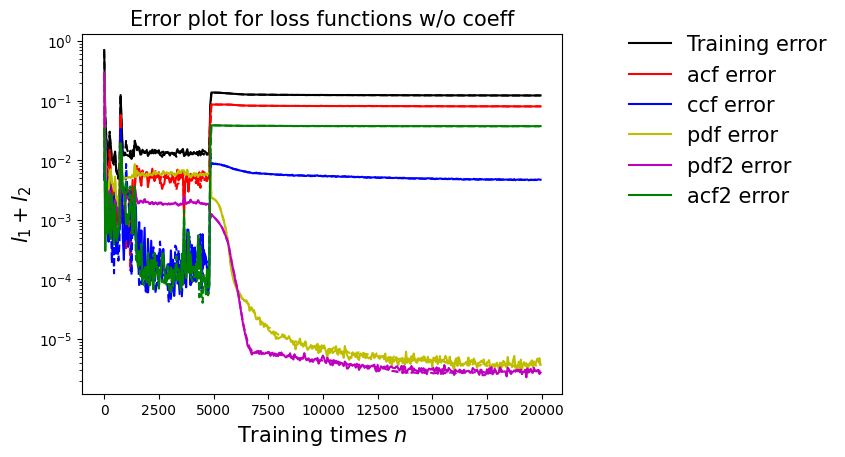

In [27]:
draw_errors(model)

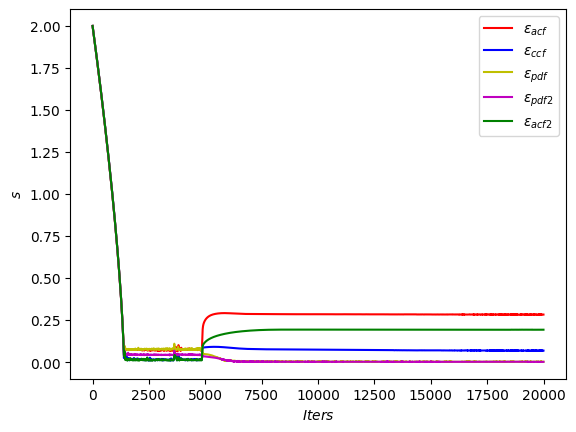

In [28]:
draw_adaptive_w(model)

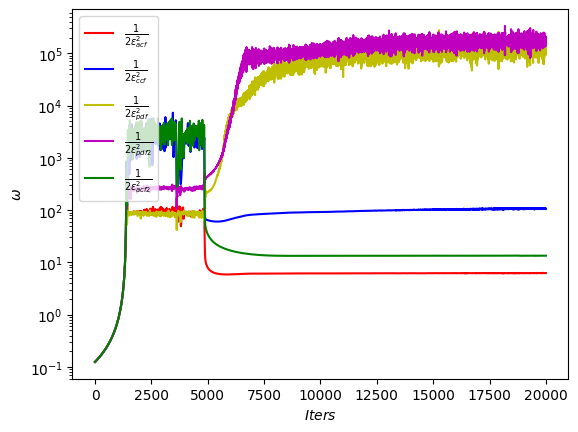

In [29]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [30]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [31]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [32]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [33]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [34]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [35]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [36]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

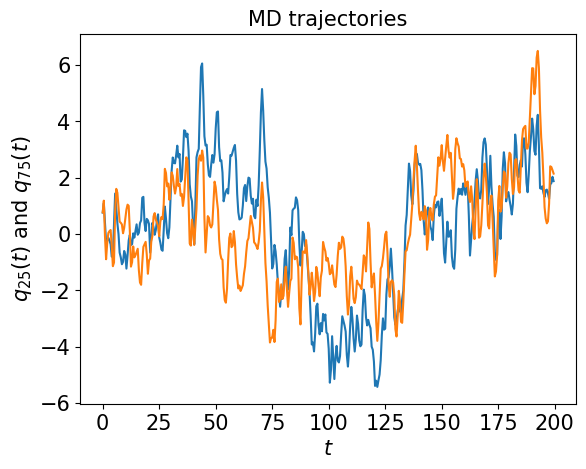

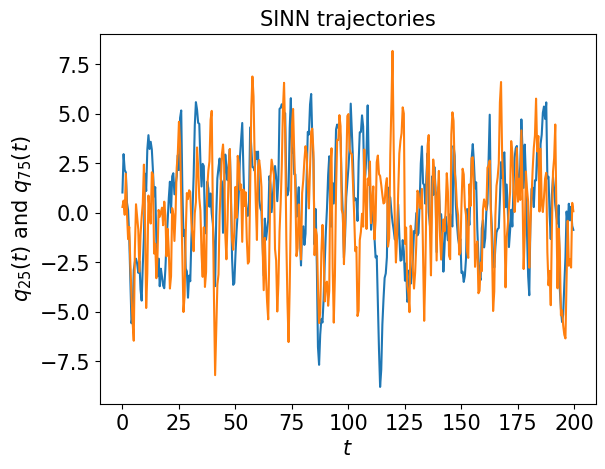

In [37]:
test1(model)

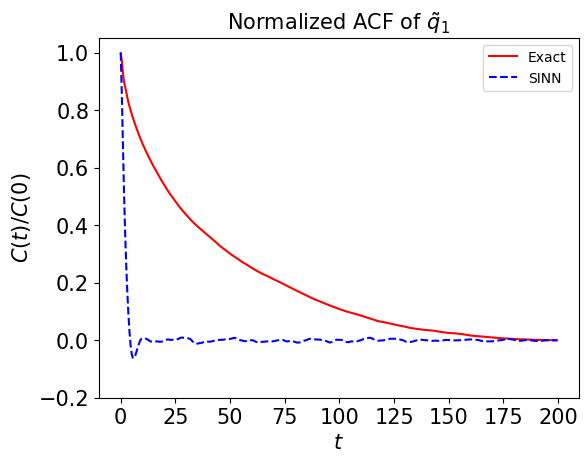

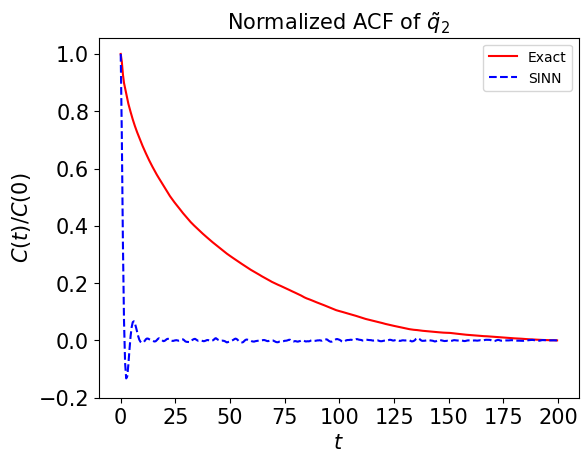

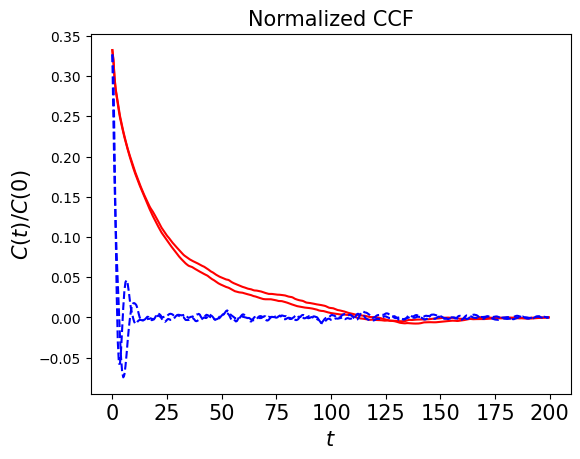

In [38]:
test2(model)

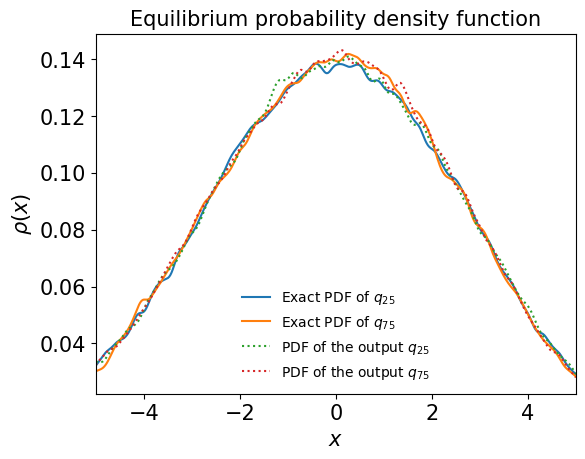

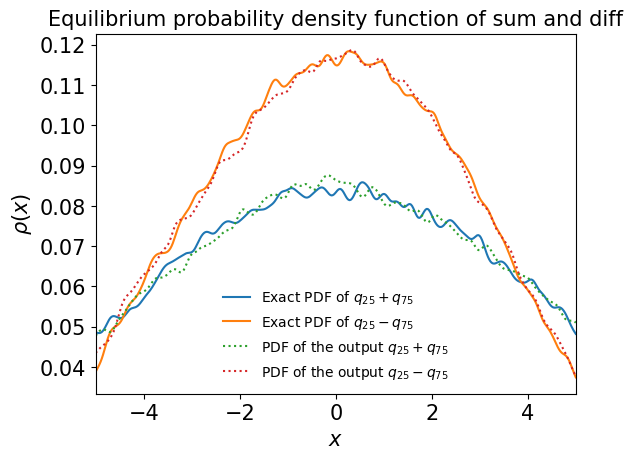

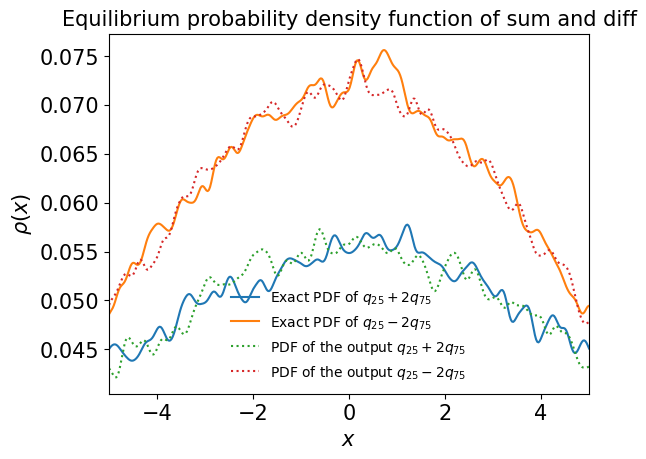

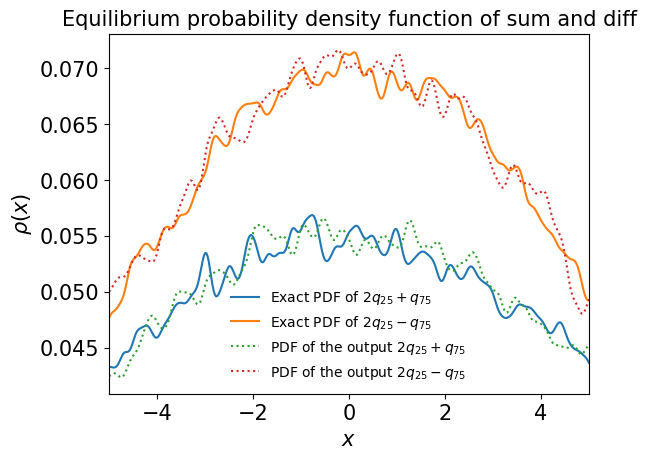

In [39]:
test3(model)

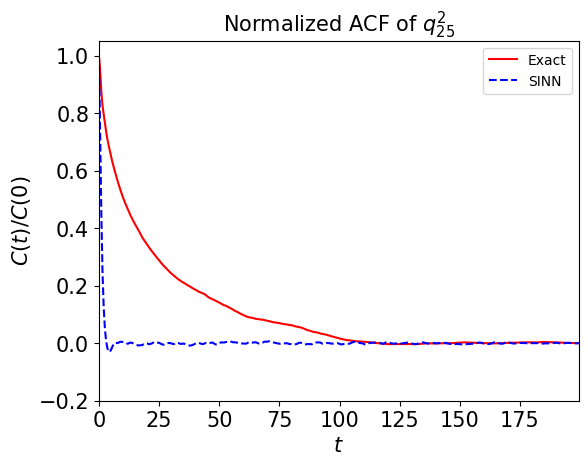

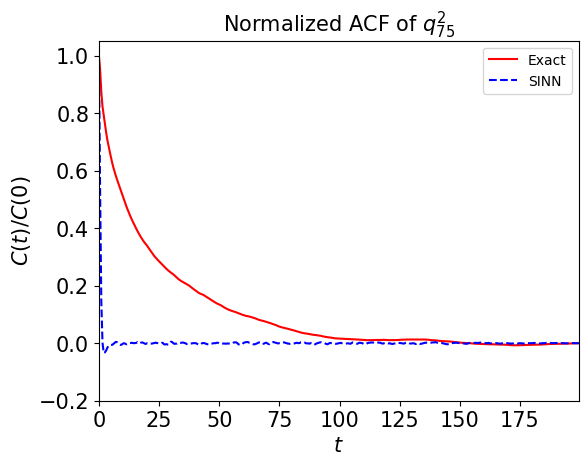

In [40]:
test4(model)

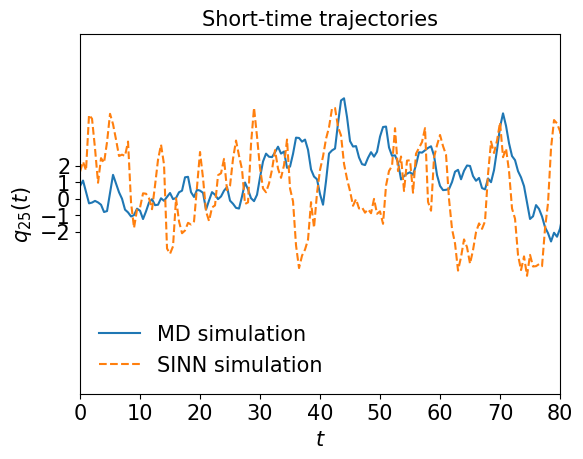

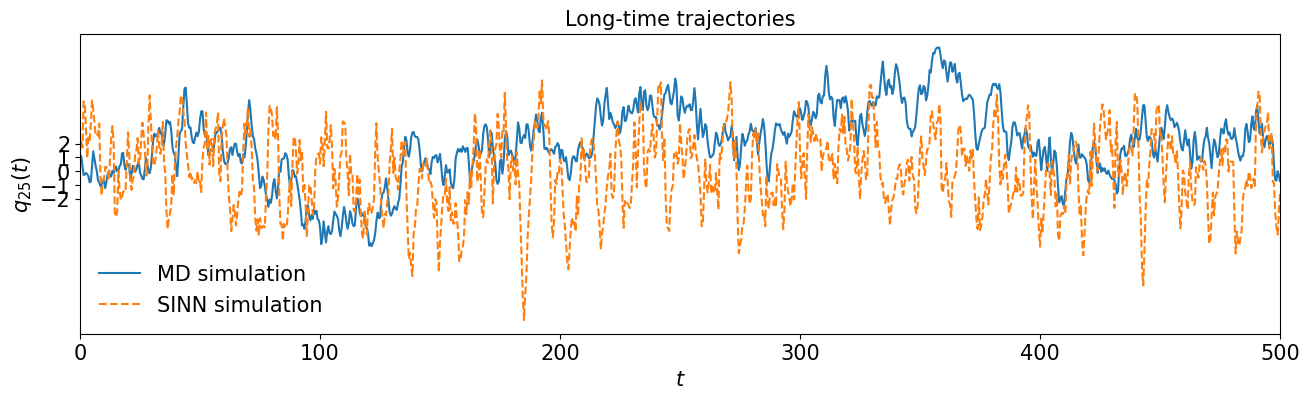

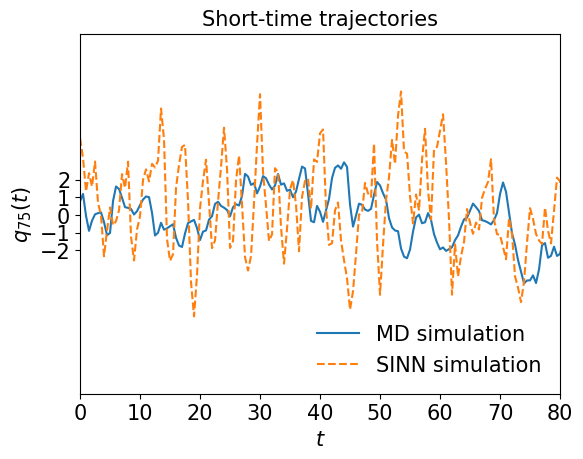

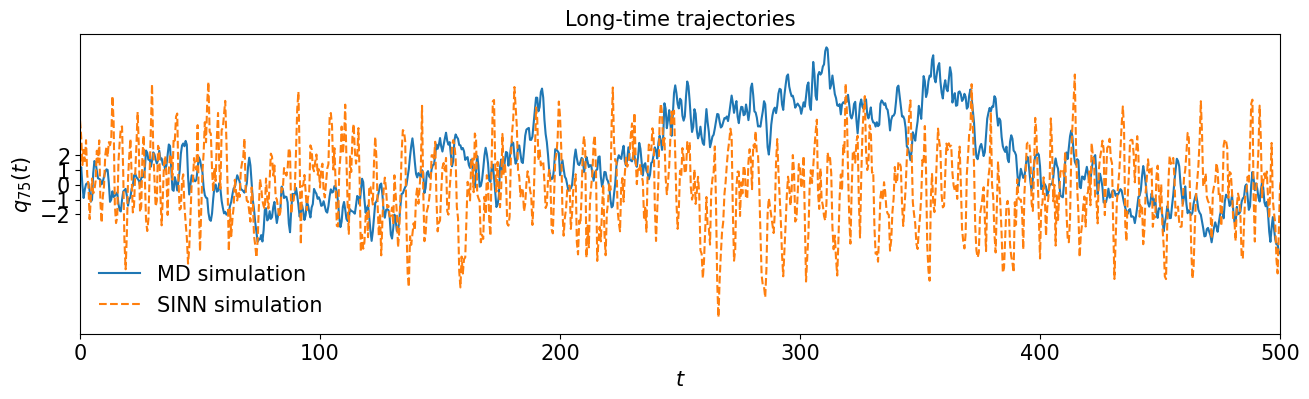

In [41]:
test5(model)

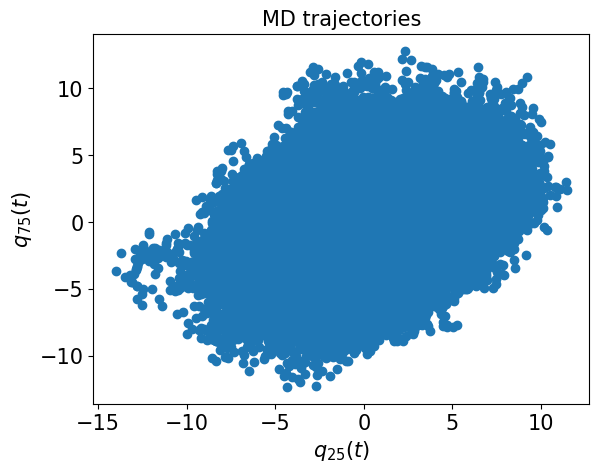

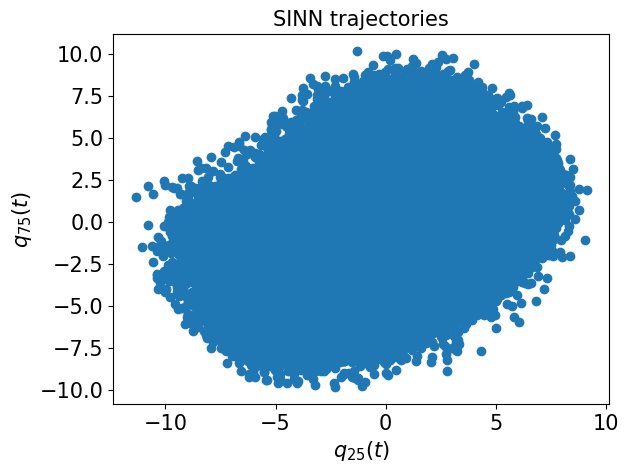

In [42]:
test6(model)

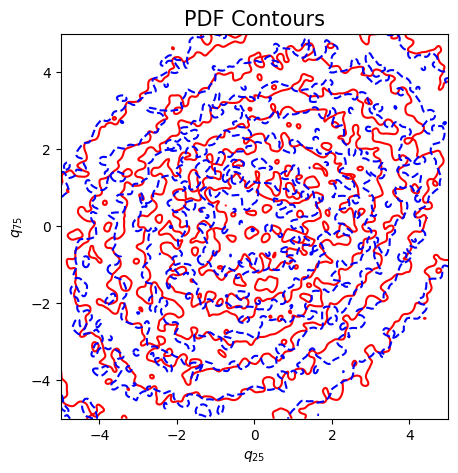

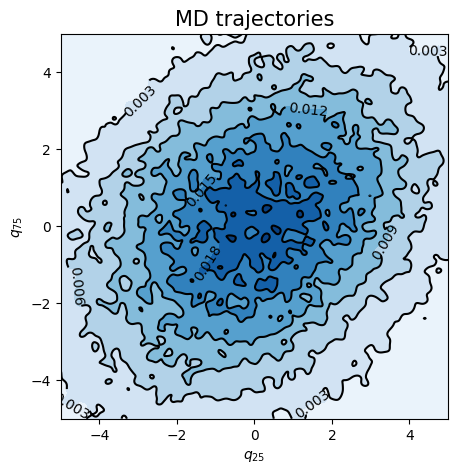

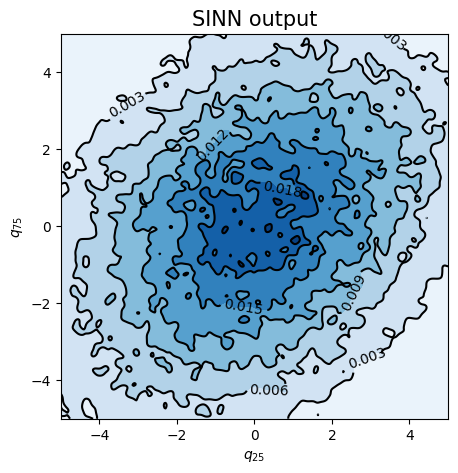

In [43]:
test7(model)

In [44]:
### Defining SINN model
net1 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.6969, 0.6838, acf: 0.07608, ccf: 0.00398, pdf: 0.28735, pdf2: 0.28437, acf2: 0.03206
[50]-th step loss: 0.0610, 0.0652, acf: 0.00598, ccf: 0.03595, pdf: 0.01636, pdf2: 0.00630, acf2: 0.00062
[100]-th step loss: 0.0161, 0.0164, acf: 0.00367, ccf: 0.00131, pdf: 0.00614, pdf2: 0.00233, acf2: 0.00298
[150]-th step loss: 0.0645, 0.0695, acf: 0.02024, ccf: 0.03581, pdf: 0.00654, pdf2: 0.00171, acf2: 0.00517
[200]-th step loss: 0.0340, 0.0346, acf: 0.01581, ccf: 0.00785, pdf: 0.00514, pdf2: 0.00333, acf2: 0.00247
[250]-th step loss: 0.0180, 0.0158, acf: 0.00479, ccf: 0.00117, pdf: 0.00471, pdf2: 0.00210, acf2: 0.00300
[300]-th step loss: 0.0113, 0.0111, acf: 0.00355, ccf: 0.00069, pdf: 0.00343, pdf2: 0.00171, acf2: 0.00171
[350]-th step loss: 0.0641, 0.0673, acf: 0.01549, ccf: 0.02541, pdf: 0.01489, pdf2: 0.00535, acf2: 0.00615
[400]-th step loss: 0.0441, 0.0434, acf: 0.01308, ccf: 0.01580, pdf: 0.00855, pdf2: 0.00414, acf2: 0.00186
[450]-th step loss: 0.0219, 0.0212, acf:

[3850]-th step loss: 0.0005, 0.0008, acf: 0.00030, ccf: 0.00031, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00018
[3900]-th step loss: 0.0004, 0.0011, acf: 0.00039, ccf: 0.00038, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00030
[3950]-th step loss: 0.0006, 0.0010, acf: 0.00038, ccf: 0.00040, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00014
[4000]-th step loss: 0.0006, 0.0008, acf: 0.00029, ccf: 0.00026, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00019
[4050]-th step loss: 0.0007, 0.0014, acf: 0.00041, ccf: 0.00069, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00023
[4100]-th step loss: 0.0005, 0.0011, acf: 0.00047, ccf: 0.00032, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00031
[4150]-th step loss: 0.0007, 0.0006, acf: 0.00028, ccf: 0.00021, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00010
[4200]-th step loss: 0.0009, 0.0013, acf: 0.00030, ccf: 0.00074, pdf: 0.00010, pdf2: 0.00002, acf2: 0.00015
[4250]-th step loss: 0.0006, 0.0007, acf: 0.00028, ccf: 0.00024, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00012
[4300]-th step loss: 0.0004,

In [45]:
### Defining SINN model
net2 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.6832, 0.6598, acf: 0.07792, ccf: 0.00613, pdf: 0.28016, pdf2: 0.26163, acf2: 0.03400
[50]-th step loss: 0.0779, 0.0753, acf: 0.04709, ccf: 0.00398, pdf: 0.00406, pdf2: 0.00209, acf2: 0.01807
[100]-th step loss: 0.0502, 0.0468, acf: 0.01514, ccf: 0.01075, pdf: 0.01034, pdf2: 0.00279, acf2: 0.00783
[150]-th step loss: 0.0217, 0.0338, acf: 0.01123, ccf: 0.00091, pdf: 0.00903, pdf2: 0.00363, acf2: 0.00899
[200]-th step loss: 0.0413, 0.0370, acf: 0.01309, ccf: 0.01047, pdf: 0.00555, pdf2: 0.00510, acf2: 0.00277
[250]-th step loss: 0.0371, 0.0369, acf: 0.01013, ccf: 0.01854, pdf: 0.00297, pdf2: 0.00297, acf2: 0.00227
[300]-th step loss: 0.0418, 0.0418, acf: 0.01006, ccf: 0.01984, pdf: 0.00678, pdf2: 0.00300, acf2: 0.00211
[350]-th step loss: 0.0378, 0.0376, acf: 0.01119, ccf: 0.01830, pdf: 0.00421, pdf2: 0.00289, acf2: 0.00099
[400]-th step loss: 0.1526, 0.1816, acf: 0.06541, ccf: 0.00523, pdf: 0.04568, pdf2: 0.03965, acf2: 0.02566
[450]-th step loss: 0.0800, 0.0538, acf:

[3850]-th step loss: 0.0010, 0.0005, acf: 0.00009, ccf: 0.00011, pdf: 0.00009, pdf2: 0.00004, acf2: 0.00022
[3900]-th step loss: 0.0015, 0.0004, acf: 0.00008, ccf: 0.00013, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00009
[3950]-th step loss: 0.0004, 0.0006, acf: 0.00032, ccf: 0.00005, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00018
[4000]-th step loss: 0.0008, 0.0005, acf: 0.00026, ccf: 0.00007, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00016
[4050]-th step loss: 0.0004, 0.0005, acf: 0.00013, ccf: 0.00016, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00012
Training finished
Training time: 438.86
Training time per iteration: 0.11
Number of Iterations:4051


In [46]:
### Defining SINN model
net3 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.6976, 0.6868, acf: 0.07461, ccf: 0.00540, pdf: 0.28820, pdf2: 0.28780, acf2: 0.03081
[50]-th step loss: 0.0882, 0.0877, acf: 0.03385, ccf: 0.01675, pdf: 0.01532, pdf2: 0.00818, acf2: 0.01355
[100]-th step loss: 0.0388, 0.0383, acf: 0.00981, ccf: 0.02009, pdf: 0.00482, pdf2: 0.00269, acf2: 0.00093
[150]-th step loss: 0.0259, 0.0263, acf: 0.00866, ccf: 0.01257, pdf: 0.00227, pdf2: 0.00120, acf2: 0.00160
[200]-th step loss: 0.0158, 0.0147, acf: 0.00410, ccf: 0.00604, pdf: 0.00211, pdf2: 0.00115, acf2: 0.00134
[250]-th step loss: 0.0357, 0.0366, acf: 0.01177, ccf: 0.01129, pdf: 0.01077, pdf2: 0.00097, acf2: 0.00181
[300]-th step loss: 0.0104, 0.0098, acf: 0.00450, ccf: 0.00068, pdf: 0.00186, pdf2: 0.00090, acf2: 0.00182
[350]-th step loss: 0.0161, 0.0140, acf: 0.00531, ccf: 0.00554, pdf: 0.00114, pdf2: 0.00081, acf2: 0.00119
[400]-th step loss: 0.0509, 0.0486, acf: 0.03015, ccf: 0.00376, pdf: 0.00530, pdf2: 0.00094, acf2: 0.00848
[450]-th step loss: 0.0156, 0.0136, acf:

[3850]-th step loss: 0.0144, 0.0163, acf: 0.00867, ccf: 0.00008, pdf: 0.00559, pdf2: 0.00182, acf2: 0.00016
[3900]-th step loss: 0.0155, 0.0168, acf: 0.00869, ccf: 0.00016, pdf: 0.00596, pdf2: 0.00186, acf2: 0.00012
[3950]-th step loss: 0.0170, 0.0183, acf: 0.00967, ccf: 0.00008, pdf: 0.00636, pdf2: 0.00194, acf2: 0.00022
[4000]-th step loss: 0.0163, 0.0167, acf: 0.00875, ccf: 0.00005, pdf: 0.00593, pdf2: 0.00184, acf2: 0.00015
[4050]-th step loss: 0.0142, 0.0158, acf: 0.00824, ccf: 0.00012, pdf: 0.00543, pdf2: 0.00185, acf2: 0.00015
[4100]-th step loss: 0.0158, 0.0171, acf: 0.00913, ccf: 0.00007, pdf: 0.00592, pdf2: 0.00182, acf2: 0.00019
[4150]-th step loss: 0.0156, 0.0169, acf: 0.00838, ccf: 0.00006, pdf: 0.00638, pdf2: 0.00188, acf2: 0.00015
[4200]-th step loss: 0.0134, 0.0160, acf: 0.00839, ccf: 0.00004, pdf: 0.00564, pdf2: 0.00182, acf2: 0.00014
[4250]-th step loss: 0.0150, 0.0160, acf: 0.00826, ccf: 0.00005, pdf: 0.00559, pdf2: 0.00187, acf2: 0.00019
[4300]-th step loss: 0.0131,

[7650]-th step loss: 0.0139, 0.0147, acf: 0.00680, ccf: 0.00006, pdf: 0.00605, pdf2: 0.00178, acf2: 0.00006
[7700]-th step loss: 0.0140, 0.0150, acf: 0.00740, ccf: 0.00008, pdf: 0.00554, pdf2: 0.00192, acf2: 0.00009
[7750]-th step loss: 0.0152, 0.0161, acf: 0.00802, ccf: 0.00007, pdf: 0.00616, pdf2: 0.00177, acf2: 0.00009
[7800]-th step loss: 0.0151, 0.0148, acf: 0.00706, ccf: 0.00009, pdf: 0.00582, pdf2: 0.00175, acf2: 0.00009
[7850]-th step loss: 0.0141, 0.0148, acf: 0.00697, ccf: 0.00006, pdf: 0.00589, pdf2: 0.00178, acf2: 0.00007
[7900]-th step loss: 0.0139, 0.0141, acf: 0.00640, ccf: 0.00007, pdf: 0.00572, pdf2: 0.00182, acf2: 0.00005
[7950]-th step loss: 0.0148, 0.0150, acf: 0.00732, ccf: 0.00006, pdf: 0.00577, pdf2: 0.00178, acf2: 0.00008
[8000]-th step loss: 0.0153, 0.0154, acf: 0.00737, ccf: 0.00004, pdf: 0.00612, pdf2: 0.00178, acf2: 0.00007
[8050]-th step loss: 0.0144, 0.0146, acf: 0.00694, ccf: 0.00004, pdf: 0.00576, pdf2: 0.00177, acf2: 0.00006
[8100]-th step loss: 0.0143,

[11450]-th step loss: 0.0131, 0.0143, acf: 0.00652, ccf: 0.00012, pdf: 0.00588, pdf2: 0.00172, acf2: 0.00006
[11500]-th step loss: 0.0150, 0.0150, acf: 0.00716, ccf: 0.00006, pdf: 0.00594, pdf2: 0.00175, acf2: 0.00007
[11550]-th step loss: 0.0131, 0.0138, acf: 0.00608, ccf: 0.00008, pdf: 0.00576, pdf2: 0.00177, acf2: 0.00007
[11600]-th step loss: 0.0164, 0.0141, acf: 0.00626, ccf: 0.00004, pdf: 0.00602, pdf2: 0.00174, acf2: 0.00004
[11650]-th step loss: 0.0135, 0.0145, acf: 0.00660, ccf: 0.00009, pdf: 0.00599, pdf2: 0.00173, acf2: 0.00004
[11700]-th step loss: 0.0148, 0.0147, acf: 0.00697, ccf: 0.00007, pdf: 0.00576, pdf2: 0.00178, acf2: 0.00009
[11750]-th step loss: 0.0139, 0.0143, acf: 0.00666, ccf: 0.00007, pdf: 0.00574, pdf2: 0.00177, acf2: 0.00005
[11800]-th step loss: 0.0135, 0.0140, acf: 0.00635, ccf: 0.00004, pdf: 0.00584, pdf2: 0.00174, acf2: 0.00006
[11850]-th step loss: 0.0164, 0.0146, acf: 0.00676, ccf: 0.00008, pdf: 0.00589, pdf2: 0.00175, acf2: 0.00008
[11900]-th step los

[15250]-th step loss: 0.0132, 0.0141, acf: 0.00637, ccf: 0.00010, pdf: 0.00584, pdf2: 0.00174, acf2: 0.00003
[15300]-th step loss: 0.0158, 0.0163, acf: 0.00731, ccf: 0.00004, pdf: 0.00702, pdf2: 0.00186, acf2: 0.00007
[15350]-th step loss: 0.0138, 0.0140, acf: 0.00630, ccf: 0.00008, pdf: 0.00580, pdf2: 0.00175, acf2: 0.00005
[15400]-th step loss: 0.0132, 0.0135, acf: 0.00557, ccf: 0.00023, pdf: 0.00583, pdf2: 0.00178, acf2: 0.00005
[15450]-th step loss: 0.0156, 0.0149, acf: 0.00706, ccf: 0.00009, pdf: 0.00590, pdf2: 0.00175, acf2: 0.00013
[15500]-th step loss: 0.0140, 0.0143, acf: 0.00659, ccf: 0.00006, pdf: 0.00587, pdf2: 0.00175, acf2: 0.00005
[15550]-th step loss: 0.0151, 0.0139, acf: 0.00614, ccf: 0.00010, pdf: 0.00593, pdf2: 0.00173, acf2: 0.00004
[15600]-th step loss: 0.0129, 0.0143, acf: 0.00656, ccf: 0.00011, pdf: 0.00585, pdf2: 0.00173, acf2: 0.00007
[15650]-th step loss: 0.0146, 0.0142, acf: 0.00645, ccf: 0.00006, pdf: 0.00592, pdf2: 0.00174, acf2: 0.00007
[15700]-th step los

[19050]-th step loss: 0.0138, 0.0149, acf: 0.00705, ccf: 0.00007, pdf: 0.00595, pdf2: 0.00171, acf2: 0.00008
[19100]-th step loss: 0.0230, 0.0246, acf: 0.00744, ccf: 0.00284, pdf: 0.01229, pdf2: 0.00123, acf2: 0.00076
[19150]-th step loss: 0.0170, 0.0168, acf: 0.00556, ccf: 0.00038, pdf: 0.00950, pdf2: 0.00088, acf2: 0.00050
[19200]-th step loss: 0.0120, 0.0135, acf: 0.00465, ccf: 0.00047, pdf: 0.00738, pdf2: 0.00062, acf2: 0.00041
[19250]-th step loss: 0.0087, 0.0095, acf: 0.00423, ccf: 0.00053, pdf: 0.00404, pdf2: 0.00034, acf2: 0.00034
[19300]-th step loss: 0.0094, 0.0110, acf: 0.00459, ccf: 0.00064, pdf: 0.00467, pdf2: 0.00091, acf2: 0.00025
[19350]-th step loss: 0.0025, 0.0030, acf: 0.00085, ccf: 0.00061, pdf: 0.00101, pdf2: 0.00012, acf2: 0.00036
[19400]-th step loss: 0.0016, 0.0016, acf: 0.00077, ccf: 0.00031, pdf: 0.00030, pdf2: 0.00004, acf2: 0.00023
[19450]-th step loss: 0.0010, 0.0029, acf: 0.00089, ccf: 0.00136, pdf: 0.00025, pdf2: 0.00007, acf2: 0.00029
[19500]-th step los

In [47]:
### Defining SINN model
net4 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.7059, 0.6866, acf: 0.07853, ccf: 0.00419, pdf: 0.28694, pdf2: 0.28277, acf2: 0.03414
[50]-th step loss: 0.0634, 0.0652, acf: 0.02399, ccf: 0.01882, pdf: 0.01083, pdf2: 0.00587, acf2: 0.00566
[100]-th step loss: 0.0239, 0.0227, acf: 0.00859, ccf: 0.00588, pdf: 0.00465, pdf2: 0.00182, acf2: 0.00174
[150]-th step loss: 0.0248, 0.0320, acf: 0.00170, ccf: 0.01030, pdf: 0.01273, pdf2: 0.00350, acf2: 0.00378
[200]-th step loss: 0.0179, 0.0182, acf: 0.00354, ccf: 0.00674, pdf: 0.00428, pdf2: 0.00217, acf2: 0.00145
[250]-th step loss: 0.0084, 0.0085, acf: 0.00191, ccf: 0.00034, pdf: 0.00292, pdf2: 0.00185, acf2: 0.00148
[300]-th step loss: 0.0352, 0.0368, acf: 0.01688, ccf: 0.01005, pdf: 0.00559, pdf2: 0.00119, acf2: 0.00308
[350]-th step loss: 0.0274, 0.0267, acf: 0.01095, ccf: 0.00657, pdf: 0.00651, pdf2: 0.00136, acf2: 0.00134
[400]-th step loss: 0.0361, 0.0226, acf: 0.01213, ccf: 0.00252, pdf: 0.00422, pdf2: 0.00197, acf2: 0.00175
[450]-th step loss: 0.0146, 0.0163, acf:

[3850]-th step loss: 0.0022, 0.0021, acf: 0.00020, ccf: 0.00074, pdf: 0.00051, pdf2: 0.00005, acf2: 0.00059
[3900]-th step loss: 0.0024, 0.0016, acf: 0.00036, ccf: 0.00020, pdf: 0.00028, pdf2: 0.00003, acf2: 0.00076
[3950]-th step loss: 0.0012, 0.0017, acf: 0.00016, ccf: 0.00091, pdf: 0.00020, pdf2: 0.00002, acf2: 0.00039
[4000]-th step loss: 0.0013, 0.0010, acf: 0.00013, ccf: 0.00046, pdf: 0.00015, pdf2: 0.00002, acf2: 0.00023
[4050]-th step loss: 0.0021, 0.0011, acf: 0.00011, ccf: 0.00044, pdf: 0.00016, pdf2: 0.00002, acf2: 0.00037
[4100]-th step loss: 0.0008, 0.0008, acf: 0.00014, ccf: 0.00037, pdf: 0.00011, pdf2: 0.00002, acf2: 0.00016
[4150]-th step loss: 0.0014, 0.0015, acf: 0.00030, ccf: 0.00054, pdf: 0.00023, pdf2: 0.00003, acf2: 0.00040
[4200]-th step loss: 0.0109, 0.0209, acf: 0.00320, ccf: 0.00406, pdf: 0.00439, pdf2: 0.00194, acf2: 0.00725
[4250]-th step loss: 0.0467, 0.0470, acf: 0.01228, ccf: 0.00199, pdf: 0.01741, pdf2: 0.00443, acf2: 0.01094
[4300]-th step loss: 0.0400,

[7650]-th step loss: 0.0174, 0.0175, acf: 0.00734, ccf: 0.00136, pdf: 0.00303, pdf2: 0.00196, acf2: 0.00379
[7700]-th step loss: 0.0111, 0.0111, acf: 0.00446, ccf: 0.00111, pdf: 0.00142, pdf2: 0.00109, acf2: 0.00300
[7750]-th step loss: 0.0079, 0.0082, acf: 0.00392, ccf: 0.00084, pdf: 0.00086, pdf2: 0.00060, acf2: 0.00202
[7800]-th step loss: 0.0075, 0.0072, acf: 0.00369, ccf: 0.00083, pdf: 0.00061, pdf2: 0.00038, acf2: 0.00166
[7850]-th step loss: 0.0066, 0.0065, acf: 0.00344, ccf: 0.00090, pdf: 0.00047, pdf2: 0.00028, acf2: 0.00140
[7900]-th step loss: 0.0058, 0.0060, acf: 0.00313, ccf: 0.00093, pdf: 0.00035, pdf2: 0.00022, acf2: 0.00137
[7950]-th step loss: 0.0064, 0.0058, acf: 0.00338, ccf: 0.00077, pdf: 0.00032, pdf2: 0.00019, acf2: 0.00111
[8000]-th step loss: 0.0051, 0.0057, acf: 0.00303, ccf: 0.00090, pdf: 0.00024, pdf2: 0.00015, acf2: 0.00136
[8050]-th step loss: 0.0064, 0.0064, acf: 0.00332, ccf: 0.00153, pdf: 0.00031, pdf2: 0.00015, acf2: 0.00113
[8100]-th step loss: 0.0042,

In [48]:
### Defining SINN model
net5 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.6435, 0.6175, acf: 0.07928, ccf: 0.01314, pdf: 0.26255, pdf2: 0.22704, acf2: 0.03548
[50]-th step loss: 0.1285, 0.1288, acf: 0.03661, ccf: 0.06334, pdf: 0.00973, pdf2: 0.00916, acf2: 0.00998
[100]-th step loss: 0.0997, 0.0909, acf: 0.04386, ccf: 0.03149, pdf: 0.00409, pdf2: 0.00383, acf2: 0.00760
[150]-th step loss: 0.0398, 0.0359, acf: 0.01618, ccf: 0.00070, pdf: 0.01113, pdf2: 0.00440, acf2: 0.00349
[200]-th step loss: 0.0248, 0.0244, acf: 0.00903, ccf: 0.00670, pdf: 0.00298, pdf2: 0.00175, acf2: 0.00399
[250]-th step loss: 0.0394, 0.0368, acf: 0.01662, ccf: 0.01323, pdf: 0.00408, pdf2: 0.00194, acf2: 0.00095
[300]-th step loss: 0.0269, 0.0272, acf: 0.01458, ccf: 0.00758, pdf: 0.00224, pdf2: 0.00200, acf2: 0.00077
[350]-th step loss: 0.0284, 0.0272, acf: 0.01569, ccf: 0.00730, pdf: 0.00219, pdf2: 0.00173, acf2: 0.00031
[400]-th step loss: 0.0233, 0.0217, acf: 0.01078, ccf: 0.00735, pdf: 0.00151, pdf2: 0.00156, acf2: 0.00047
[450]-th step loss: 0.0408, 0.0423, acf:

[3850]-th step loss: 0.0341, 0.0330, acf: 0.01463, ccf: 0.00267, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01566
[3900]-th step loss: 0.0338, 0.0336, acf: 0.01486, ccf: 0.00286, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01586
[3950]-th step loss: 0.0344, 0.0332, acf: 0.01458, ccf: 0.00273, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01584
[4000]-th step loss: 0.0346, 0.0336, acf: 0.01495, ccf: 0.00289, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01569
[4050]-th step loss: 0.0343, 0.0336, acf: 0.01467, ccf: 0.00273, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01623
[4100]-th step loss: 0.0334, 0.0337, acf: 0.01471, ccf: 0.00282, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01619
[4150]-th step loss: 0.0338, 0.0336, acf: 0.01515, ccf: 0.00271, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01575
[4200]-th step loss: 0.0386, 0.0335, acf: 0.01495, ccf: 0.00265, pdf: 0.00004, pdf2: 0.00001, acf2: 0.01590
[4250]-th step loss: 0.0372, 0.0335, acf: 0.01509, ccf: 0.00266, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01574
[4300]-th step loss: 0.0338,

[7650]-th step loss: 0.0385, 0.0351, acf: 0.01646, ccf: 0.00263, pdf: 0.00002, pdf2: 0.00000, acf2: 0.01600
[7700]-th step loss: 0.0356, 0.0355, acf: 0.01666, ccf: 0.00262, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01617
[7750]-th step loss: 0.0358, 0.0358, acf: 0.01684, ccf: 0.00256, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01640
[7800]-th step loss: 0.0341, 0.0352, acf: 0.01642, ccf: 0.00254, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01624
[7850]-th step loss: 0.0347, 0.0355, acf: 0.01658, ccf: 0.00280, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01615
[7900]-th step loss: 0.0368, 0.0357, acf: 0.01677, ccf: 0.00253, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01643
[7950]-th step loss: 0.0341, 0.0358, acf: 0.01659, ccf: 0.00263, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01661
[8000]-th step loss: 0.0359, 0.0358, acf: 0.01672, ccf: 0.00252, pdf: 0.00002, pdf2: 0.00000, acf2: 0.01651
[8050]-th step loss: 0.0352, 0.0357, acf: 0.01672, ccf: 0.00253, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01640
[8100]-th step loss: 0.0349,

[11450]-th step loss: 0.0359, 0.0356, acf: 0.01727, ccf: 0.00246, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01582
[11500]-th step loss: 0.0345, 0.0358, acf: 0.01741, ccf: 0.00239, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01595
[11550]-th step loss: 0.0370, 0.0353, acf: 0.01700, ccf: 0.00250, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01574
[11600]-th step loss: 0.0373, 0.0352, acf: 0.01692, ccf: 0.00252, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01576
[11650]-th step loss: 0.0409, 0.0357, acf: 0.01728, ccf: 0.00238, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01604
[11700]-th step loss: 0.0346, 0.0346, acf: 0.01645, ccf: 0.00236, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01574
[11750]-th step loss: 0.0347, 0.0348, acf: 0.01658, ccf: 0.00236, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01585
[11800]-th step loss: 0.0353, 0.0346, acf: 0.01619, ccf: 0.00264, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01574
[11850]-th step loss: 0.0363, 0.0351, acf: 0.01681, ccf: 0.00247, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01580
[11900]-th step los

[15250]-th step loss: 0.0272, 0.0278, acf: 0.01238, ccf: 0.00136, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01401
[15300]-th step loss: 0.0283, 0.0283, acf: 0.01233, ccf: 0.00156, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01437
[15350]-th step loss: 0.0283, 0.0273, acf: 0.01226, ccf: 0.00130, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01370
[15400]-th step loss: 0.0270, 0.0265, acf: 0.01206, ccf: 0.00121, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01317
[15450]-th step loss: 0.0261, 0.0260, acf: 0.01169, ccf: 0.00138, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01295
[15500]-th step loss: 0.0260, 0.0260, acf: 0.01153, ccf: 0.00139, pdf: 0.00004, pdf2: 0.00001, acf2: 0.01303
[15550]-th step loss: 0.0252, 0.0250, acf: 0.01142, ccf: 0.00110, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01242
[15600]-th step loss: 0.0231, 0.0236, acf: 0.01116, ccf: 0.00083, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01164
[15650]-th step loss: 0.0223, 0.0222, acf: 0.01018, ccf: 0.00082, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01115
[15700]-th step los

[19050]-th step loss: 0.0128, 0.0130, acf: 0.00643, ccf: 0.00152, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00508
[19100]-th step loss: 0.0106, 0.0119, acf: 0.00503, ccf: 0.00135, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00552
[19150]-th step loss: 0.0076, 0.0070, acf: 0.00437, ccf: 0.00039, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00220
[19200]-th step loss: 0.0083, 0.0080, acf: 0.00455, ccf: 0.00089, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00255
[19250]-th step loss: 0.0078, 0.0085, acf: 0.00446, ccf: 0.00174, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00230
[19300]-th step loss: 0.0104, 0.0093, acf: 0.00508, ccf: 0.00064, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00348
[19350]-th step loss: 0.0091, 0.0100, acf: 0.00652, ccf: 0.00066, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00275
[19400]-th step loss: 0.0217, 0.0244, acf: 0.00732, ccf: 0.00162, pdf: 0.00032, pdf2: 0.00008, acf2: 0.01509
[19450]-th step loss: 0.0350, 0.0321, acf: 0.01462, ccf: 0.00375, pdf: 0.00031, pdf2: 0.00009, acf2: 0.01336
[19500]-th step los

In [49]:
### Defining SINN model
net6 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

[0]-th step loss: 0.6830, 0.6586, acf: 0.07720, ccf: 0.01541, pdf: 0.27691, pdf2: 0.25601, acf2: 0.03306
[50]-th step loss: 0.1234, 0.1230, acf: 0.04213, ccf: 0.05311, pdf: 0.00690, pdf2: 0.00709, acf2: 0.01373
[100]-th step loss: 0.0707, 0.0765, acf: 0.03258, ccf: 0.00534, pdf: 0.02163, pdf2: 0.00473, acf2: 0.01226
[150]-th step loss: 0.0238, 0.0232, acf: 0.00681, ccf: 0.00532, pdf: 0.00730, pdf2: 0.00277, acf2: 0.00104
[200]-th step loss: 0.0487, 0.0478, acf: 0.01637, ccf: 0.01232, pdf: 0.01479, pdf2: 0.00293, acf2: 0.00137
[250]-th step loss: 0.0185, 0.0188, acf: 0.00253, ccf: 0.00960, pdf: 0.00393, pdf2: 0.00193, acf2: 0.00080
[300]-th step loss: 0.0148, 0.0136, acf: 0.00303, ccf: 0.00439, pdf: 0.00387, pdf2: 0.00171, acf2: 0.00062
[350]-th step loss: 0.0100, 0.0112, acf: 0.00120, ccf: 0.00411, pdf: 0.00303, pdf2: 0.00181, acf2: 0.00102
[400]-th step loss: 0.1130, 0.0867, acf: 0.01375, ccf: 0.02799, pdf: 0.02409, pdf2: 0.00599, acf2: 0.01488
[450]-th step loss: 0.0298, 0.0293, acf:

[3850]-th step loss: 0.0591, 0.0619, acf: 0.04225, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01960
[3900]-th step loss: 0.0558, 0.0591, acf: 0.04065, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01838
[3950]-th step loss: 0.0547, 0.0547, acf: 0.03759, ccf: 0.00008, pdf: 0.00002, pdf2: 0.00001, acf2: 0.01701
[4000]-th step loss: 0.0589, 0.0555, acf: 0.03833, ccf: 0.00007, pdf: 0.00007, pdf2: 0.00001, acf2: 0.01707
[4050]-th step loss: 0.0570, 0.0570, acf: 0.03931, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00000, acf2: 0.01762
[4100]-th step loss: 0.0566, 0.0564, acf: 0.03909, ccf: 0.00006, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01721
[4150]-th step loss: 0.0572, 0.0572, acf: 0.03970, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01740
[4200]-th step loss: 0.0545, 0.0541, acf: 0.03795, ccf: 0.00004, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01603
[4250]-th step loss: 0.0551, 0.0548, acf: 0.03803, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01668
[4300]-th step loss: 0.0562,

[7650]-th step loss: 0.0644, 0.0626, acf: 0.04082, ccf: 0.00002, pdf: 0.00000, pdf2: 0.00000, acf2: 0.02177
[7700]-th step loss: 0.0646, 0.0631, acf: 0.04169, ccf: 0.00001, pdf: 0.00002, pdf2: 0.00001, acf2: 0.02133
[7750]-th step loss: 0.0640, 0.0638, acf: 0.04310, ccf: 0.00002, pdf: 0.00003, pdf2: 0.00001, acf2: 0.02060
[7800]-th step loss: 0.0626, 0.0637, acf: 0.04315, ccf: 0.00003, pdf: 0.00002, pdf2: 0.00000, acf2: 0.02049
[7850]-th step loss: 0.0643, 0.0632, acf: 0.04264, ccf: 0.00001, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02057
[7900]-th step loss: 0.0642, 0.0636, acf: 0.04238, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02121
[7950]-th step loss: 0.0644, 0.0630, acf: 0.04217, ccf: 0.00002, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02081
[8000]-th step loss: 0.0623, 0.0620, acf: 0.04178, ccf: 0.00002, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02023
[8050]-th step loss: 0.0602, 0.0619, acf: 0.04172, ccf: 0.00002, pdf: 0.00002, pdf2: 0.00001, acf2: 0.02014
[8100]-th step loss: 0.0604,

[11450]-th step loss: 0.0842, 0.0857, acf: 0.06359, ccf: 0.00002, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02208
[11500]-th step loss: 0.0844, 0.0849, acf: 0.06296, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02186
[11550]-th step loss: 0.0866, 0.0840, acf: 0.06192, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02200
[11600]-th step loss: 0.0832, 0.0817, acf: 0.05964, ccf: 0.00008, pdf: 0.00002, pdf2: 0.00001, acf2: 0.02197
[11650]-th step loss: 0.0837, 0.0831, acf: 0.06130, ccf: 0.00002, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02173
[11700]-th step loss: 0.0850, 0.0821, acf: 0.06046, ccf: 0.00002, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02161
[11750]-th step loss: 0.0811, 0.0799, acf: 0.05810, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02172
[11800]-th step loss: 0.0827, 0.0806, acf: 0.05843, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02213
[11850]-th step loss: 0.0823, 0.0827, acf: 0.06004, ccf: 0.00001, pdf: 0.00001, pdf2: 0.00000, acf2: 0.02266
[11900]-th step los

[15250]-th step loss: 0.0607, 0.0607, acf: 0.04382, ccf: 0.00009, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01680
[15300]-th step loss: 0.0626, 0.0562, acf: 0.04070, ccf: 0.00019, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01533
[15350]-th step loss: 0.0608, 0.0575, acf: 0.04223, ccf: 0.00011, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01516
[15400]-th step loss: 0.0543, 0.0552, acf: 0.04099, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01408
[15450]-th step loss: 0.0601, 0.0587, acf: 0.04335, ccf: 0.00007, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01525
[15500]-th step loss: 0.0590, 0.0574, acf: 0.04274, ccf: 0.00008, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01453
[15550]-th step loss: 0.0893, 0.0918, acf: 0.06230, ccf: 0.00127, pdf: 0.00183, pdf2: 0.00054, acf2: 0.02589
[15600]-th step loss: 0.0790, 0.0824, acf: 0.05639, ccf: 0.00060, pdf: 0.00092, pdf2: 0.00027, acf2: 0.02423
[15650]-th step loss: 0.0740, 0.0736, acf: 0.05020, ccf: 0.00030, pdf: 0.00037, pdf2: 0.00012, acf2: 0.02266
[15700]-th step los

[19050]-th step loss: 0.0620, 0.0637, acf: 0.04548, ccf: 0.00004, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01822
[19100]-th step loss: 0.0656, 0.0621, acf: 0.04406, ccf: 0.00005, pdf: 0.00000, pdf2: 0.00000, acf2: 0.01798
[19150]-th step loss: 0.0645, 0.0644, acf: 0.04608, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01831
[19200]-th step loss: 0.0634, 0.0619, acf: 0.04446, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01738
[19250]-th step loss: 0.0592, 0.0587, acf: 0.04174, ccf: 0.00011, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01686
[19300]-th step loss: 0.0603, 0.0631, acf: 0.04517, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01786
[19350]-th step loss: 0.0716, 0.0631, acf: 0.04495, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01806
[19400]-th step loss: 0.0667, 0.0646, acf: 0.04630, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01825
[19450]-th step loss: 0.0609, 0.0644, acf: 0.04578, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01855
[19500]-th step los

In [50]:
### Defining SINN model
net7 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

[0]-th step loss: 0.6832, 0.6647, acf: 0.07795, ccf: 0.00608, pdf: 0.28145, pdf2: 0.26546, acf2: 0.03374
[50]-th step loss: 0.0632, 0.0564, acf: 0.01022, ccf: 0.02494, pdf: 0.01295, pdf2: 0.00791, acf2: 0.00040
[100]-th step loss: 0.0214, 0.0151, acf: 0.00617, ccf: 0.00380, pdf: 0.00236, pdf2: 0.00125, acf2: 0.00157
[150]-th step loss: 0.0126, 0.0126, acf: 0.00382, ccf: 0.00371, pdf: 0.00328, pdf2: 0.00095, acf2: 0.00087
[200]-th step loss: 0.0207, 0.0196, acf: 0.00275, ccf: 0.00829, pdf: 0.00569, pdf2: 0.00069, acf2: 0.00213
[250]-th step loss: 0.0769, 0.0750, acf: 0.04047, ccf: 0.01497, pdf: 0.00640, pdf2: 0.00220, acf2: 0.01090
[300]-th step loss: 0.0091, 0.0087, acf: 0.00159, ccf: 0.00188, pdf: 0.00238, pdf2: 0.00117, acf2: 0.00163
[350]-th step loss: 0.0070, 0.0088, acf: 0.00290, ccf: 0.00129, pdf: 0.00226, pdf2: 0.00188, acf2: 0.00050
[400]-th step loss: 0.0057, 0.0061, acf: 0.00095, ccf: 0.00161, pdf: 0.00185, pdf2: 0.00121, acf2: 0.00050
[450]-th step loss: 0.0044, 0.0049, acf:

[3850]-th step loss: 0.0134, 0.0145, acf: 0.00669, ccf: 0.00014, pdf: 0.00583, pdf2: 0.00177, acf2: 0.00011
[3900]-th step loss: 0.0145, 0.0157, acf: 0.00753, ccf: 0.00033, pdf: 0.00603, pdf2: 0.00174, acf2: 0.00010
[3950]-th step loss: 0.0146, 0.0157, acf: 0.00714, ccf: 0.00050, pdf: 0.00619, pdf2: 0.00176, acf2: 0.00009
[4000]-th step loss: 0.0128, 0.0147, acf: 0.00672, ccf: 0.00023, pdf: 0.00588, pdf2: 0.00176, acf2: 0.00009
[4050]-th step loss: 0.0145, 0.0156, acf: 0.00754, ccf: 0.00033, pdf: 0.00584, pdf2: 0.00177, acf2: 0.00014
[4100]-th step loss: 0.0143, 0.0146, acf: 0.00666, ccf: 0.00017, pdf: 0.00594, pdf2: 0.00174, acf2: 0.00010
[4150]-th step loss: 0.0143, 0.0156, acf: 0.00704, ccf: 0.00055, pdf: 0.00615, pdf2: 0.00174, acf2: 0.00007
[4200]-th step loss: 0.0134, 0.0152, acf: 0.00676, ccf: 0.00040, pdf: 0.00621, pdf2: 0.00174, acf2: 0.00009
[4250]-th step loss: 0.0136, 0.0154, acf: 0.00759, ccf: 0.00021, pdf: 0.00572, pdf2: 0.00180, acf2: 0.00013
[4300]-th step loss: 0.0142,

[7650]-th step loss: 0.0152, 0.0145, acf: 0.00655, ccf: 0.00020, pdf: 0.00585, pdf2: 0.00177, acf2: 0.00009
[7700]-th step loss: 0.0136, 0.0139, acf: 0.00619, ccf: 0.00009, pdf: 0.00575, pdf2: 0.00178, acf2: 0.00010
[7750]-th step loss: 0.0139, 0.0158, acf: 0.00769, ccf: 0.00021, pdf: 0.00595, pdf2: 0.00177, acf2: 0.00013
[7800]-th step loss: 0.0132, 0.0138, acf: 0.00600, ccf: 0.00010, pdf: 0.00575, pdf2: 0.00179, acf2: 0.00011
[7850]-th step loss: 0.0141, 0.0145, acf: 0.00670, ccf: 0.00014, pdf: 0.00570, pdf2: 0.00182, acf2: 0.00010
[7900]-th step loss: 0.0150, 0.0145, acf: 0.00673, ccf: 0.00011, pdf: 0.00582, pdf2: 0.00178, acf2: 0.00009
[7950]-th step loss: 0.0137, 0.0145, acf: 0.00677, ccf: 0.00011, pdf: 0.00569, pdf2: 0.00182, acf2: 0.00011
[8000]-th step loss: 0.0146, 0.0147, acf: 0.00656, ccf: 0.00021, pdf: 0.00607, pdf2: 0.00175, acf2: 0.00009
[8050]-th step loss: 0.0123, 0.0145, acf: 0.00659, ccf: 0.00019, pdf: 0.00580, pdf2: 0.00177, acf2: 0.00011
[8100]-th step loss: 0.0141,

[11450]-th step loss: 0.0137, 0.0132, acf: 0.00548, ccf: 0.00009, pdf: 0.00574, pdf2: 0.00177, acf2: 0.00014
[11500]-th step loss: 0.0137, 0.0136, acf: 0.00580, ccf: 0.00008, pdf: 0.00582, pdf2: 0.00176, acf2: 0.00010
[11550]-th step loss: 0.0127, 0.0135, acf: 0.00587, ccf: 0.00006, pdf: 0.00567, pdf2: 0.00181, acf2: 0.00010
[11600]-th step loss: 0.0120, 0.0135, acf: 0.00544, ccf: 0.00033, pdf: 0.00584, pdf2: 0.00175, acf2: 0.00012
[11650]-th step loss: 0.0123, 0.0143, acf: 0.00592, ccf: 0.00027, pdf: 0.00627, pdf2: 0.00173, acf2: 0.00009
[11700]-th step loss: 0.0137, 0.0147, acf: 0.00633, ccf: 0.00018, pdf: 0.00636, pdf2: 0.00173, acf2: 0.00008
[11750]-th step loss: 0.0154, 0.0150, acf: 0.00690, ccf: 0.00020, pdf: 0.00606, pdf2: 0.00173, acf2: 0.00013
[11800]-th step loss: 0.0133, 0.0136, acf: 0.00563, ccf: 0.00008, pdf: 0.00600, pdf2: 0.00175, acf2: 0.00011
[11850]-th step loss: 0.0141, 0.0140, acf: 0.00593, ccf: 0.00012, pdf: 0.00599, pdf2: 0.00179, acf2: 0.00012
[11900]-th step los

[15250]-th step loss: 0.0145, 0.0140, acf: 0.00584, ccf: 0.00015, pdf: 0.00616, pdf2: 0.00171, acf2: 0.00011
[15300]-th step loss: 0.0136, 0.0140, acf: 0.00591, ccf: 0.00025, pdf: 0.00595, pdf2: 0.00174, acf2: 0.00011
[15350]-th step loss: 0.0123, 0.0133, acf: 0.00551, ccf: 0.00015, pdf: 0.00569, pdf2: 0.00182, acf2: 0.00010
[15400]-th step loss: 0.0142, 0.0151, acf: 0.00712, ccf: 0.00016, pdf: 0.00591, pdf2: 0.00175, acf2: 0.00019
[15450]-th step loss: 0.0134, 0.0134, acf: 0.00543, ccf: 0.00010, pdf: 0.00600, pdf2: 0.00174, acf2: 0.00011
[15500]-th step loss: 0.0128, 0.0139, acf: 0.00584, ccf: 0.00009, pdf: 0.00616, pdf2: 0.00175, acf2: 0.00011
[15550]-th step loss: 0.0146, 0.0137, acf: 0.00579, ccf: 0.00014, pdf: 0.00596, pdf2: 0.00173, acf2: 0.00011
[15600]-th step loss: 0.0137, 0.0137, acf: 0.00575, ccf: 0.00010, pdf: 0.00606, pdf2: 0.00172, acf2: 0.00010
[15650]-th step loss: 0.0126, 0.0138, acf: 0.00547, ccf: 0.00028, pdf: 0.00627, pdf2: 0.00169, acf2: 0.00010
[15700]-th step los

[19050]-th step loss: 0.0128, 0.0129, acf: 0.00442, ccf: 0.00024, pdf: 0.00636, pdf2: 0.00170, acf2: 0.00018
[19100]-th step loss: 0.0115, 0.0132, acf: 0.00508, ccf: 0.00012, pdf: 0.00611, pdf2: 0.00173, acf2: 0.00011
[19150]-th step loss: 0.0126, 0.0133, acf: 0.00540, ccf: 0.00015, pdf: 0.00583, pdf2: 0.00176, acf2: 0.00012
[19200]-th step loss: 0.0133, 0.0136, acf: 0.00563, ccf: 0.00018, pdf: 0.00592, pdf2: 0.00173, acf2: 0.00012
[19250]-th step loss: 0.0130, 0.0132, acf: 0.00529, ccf: 0.00025, pdf: 0.00585, pdf2: 0.00174, acf2: 0.00010
[19300]-th step loss: 0.0134, 0.0129, acf: 0.00508, ccf: 0.00017, pdf: 0.00582, pdf2: 0.00174, acf2: 0.00011
[19350]-th step loss: 0.0112, 0.0132, acf: 0.00518, ccf: 0.00022, pdf: 0.00603, pdf2: 0.00170, acf2: 0.00010
[19400]-th step loss: 0.0123, 0.0128, acf: 0.00488, ccf: 0.00021, pdf: 0.00588, pdf2: 0.00174, acf2: 0.00012
[19450]-th step loss: 0.0133, 0.0148, acf: 0.00651, ccf: 0.00012, pdf: 0.00624, pdf2: 0.00176, acf2: 0.00017
[19500]-th step los

In [51]:
### Defining SINN model
net8 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

[0]-th step loss: 0.6980, 0.6778, acf: 0.07493, ccf: 0.00429, pdf: 0.28628, pdf2: 0.28111, acf2: 0.03116
[50]-th step loss: 0.0723, 0.0716, acf: 0.01527, ccf: 0.02494, pdf: 0.01854, pdf2: 0.01150, acf2: 0.00138
[100]-th step loss: 0.0413, 0.0397, acf: 0.01220, ccf: 0.01880, pdf: 0.00380, pdf2: 0.00403, acf2: 0.00090
[150]-th step loss: 0.0313, 0.0278, acf: 0.00775, ccf: 0.01544, pdf: 0.00342, pdf2: 0.00070, acf2: 0.00050
[200]-th step loss: 0.0180, 0.0131, acf: 0.00590, ccf: 0.00036, pdf: 0.00246, pdf2: 0.00152, acf2: 0.00284
[250]-th step loss: 0.0177, 0.0155, acf: 0.00204, ccf: 0.00594, pdf: 0.00201, pdf2: 0.00131, acf2: 0.00420
[300]-th step loss: 0.0743, 0.0718, acf: 0.04219, ccf: 0.00486, pdf: 0.00204, pdf2: 0.00201, acf2: 0.02071
[350]-th step loss: 0.0168, 0.0168, acf: 0.00944, ccf: 0.00047, pdf: 0.00404, pdf2: 0.00190, acf2: 0.00097
[400]-th step loss: 0.0138, 0.0135, acf: 0.00147, ccf: 0.00024, pdf: 0.00238, pdf2: 0.00295, acf2: 0.00648
[450]-th step loss: 0.0123, 0.0110, acf:

[3850]-th step loss: 0.0163, 0.0149, acf: 0.00632, ccf: 0.00018, pdf: 0.00604, pdf2: 0.00226, acf2: 0.00013
[3900]-th step loss: 0.0135, 0.0138, acf: 0.00529, ccf: 0.00018, pdf: 0.00581, pdf2: 0.00225, acf2: 0.00028
[3950]-th step loss: 0.0160, 0.0143, acf: 0.00589, ccf: 0.00007, pdf: 0.00595, pdf2: 0.00222, acf2: 0.00021
[4000]-th step loss: 0.0147, 0.0136, acf: 0.00539, ccf: 0.00009, pdf: 0.00573, pdf2: 0.00219, acf2: 0.00021
[4050]-th step loss: 0.0164, 0.0153, acf: 0.00681, ccf: 0.00014, pdf: 0.00609, pdf2: 0.00216, acf2: 0.00012
[4100]-th step loss: 0.0144, 0.0149, acf: 0.00620, ccf: 0.00008, pdf: 0.00617, pdf2: 0.00221, acf2: 0.00024
[4150]-th step loss: 0.0157, 0.0148, acf: 0.00589, ccf: 0.00017, pdf: 0.00616, pdf2: 0.00218, acf2: 0.00037
[4200]-th step loss: 0.0157, 0.0147, acf: 0.00601, ccf: 0.00027, pdf: 0.00612, pdf2: 0.00220, acf2: 0.00014
[4250]-th step loss: 0.0144, 0.0140, acf: 0.00597, ccf: 0.00006, pdf: 0.00579, pdf2: 0.00211, acf2: 0.00009
[4300]-th step loss: 0.0129,

[7650]-th step loss: 0.0127, 0.0118, acf: 0.00376, ccf: 0.00008, pdf: 0.00599, pdf2: 0.00185, acf2: 0.00011
[7700]-th step loss: 0.0128, 0.0121, acf: 0.00371, ccf: 0.00004, pdf: 0.00635, pdf2: 0.00192, acf2: 0.00011
[7750]-th step loss: 0.0136, 0.0121, acf: 0.00385, ccf: 0.00015, pdf: 0.00604, pdf2: 0.00191, acf2: 0.00013
[7800]-th step loss: 0.0148, 0.0124, acf: 0.00436, ccf: 0.00009, pdf: 0.00595, pdf2: 0.00190, acf2: 0.00006
[7850]-th step loss: 0.0131, 0.0121, acf: 0.00365, ccf: 0.00005, pdf: 0.00653, pdf2: 0.00179, acf2: 0.00010
[7900]-th step loss: 0.0126, 0.0119, acf: 0.00384, ccf: 0.00005, pdf: 0.00612, pdf2: 0.00180, acf2: 0.00011
[7950]-th step loss: 0.0123, 0.0119, acf: 0.00375, ccf: 0.00006, pdf: 0.00614, pdf2: 0.00181, acf2: 0.00014
[8000]-th step loss: 0.0124, 0.0127, acf: 0.00367, ccf: 0.00005, pdf: 0.00701, pdf2: 0.00184, acf2: 0.00009
[8050]-th step loss: 0.0125, 0.0119, acf: 0.00397, ccf: 0.00004, pdf: 0.00605, pdf2: 0.00178, acf2: 0.00009
[8100]-th step loss: 0.0123,

In [52]:
### Defining SINN model
net9 = SINN(2, 50, 2, 2,'GRU').to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

[0]-th step loss: 0.6705, 0.6439, acf: 0.07801, ccf: 0.00517, pdf: 0.27477, pdf2: 0.25193, acf2: 0.03399
[50]-th step loss: 0.0775, 0.0751, acf: 0.02781, ccf: 0.01798, pdf: 0.00728, pdf2: 0.01025, acf2: 0.01181
[100]-th step loss: 0.0529, 0.0559, acf: 0.00667, ccf: 0.03366, pdf: 0.00482, pdf2: 0.00848, acf2: 0.00225
[150]-th step loss: 0.0500, 0.0469, acf: 0.00851, ccf: 0.02575, pdf: 0.00349, pdf2: 0.00671, acf2: 0.00242
[200]-th step loss: 0.0444, 0.0423, acf: 0.01234, ccf: 0.01909, pdf: 0.00320, pdf2: 0.00468, acf2: 0.00295
[250]-th step loss: 0.0346, 0.0313, acf: 0.00887, ccf: 0.01645, pdf: 0.00238, pdf2: 0.00157, acf2: 0.00202
[300]-th step loss: 0.0178, 0.0150, acf: 0.00545, ccf: 0.00108, pdf: 0.00404, pdf2: 0.00197, acf2: 0.00244
[350]-th step loss: 0.0367, 0.0290, acf: 0.01661, ccf: 0.00400, pdf: 0.00418, pdf2: 0.00210, acf2: 0.00212
[400]-th step loss: 0.0170, 0.0142, acf: 0.00309, ccf: 0.00482, pdf: 0.00381, pdf2: 0.00179, acf2: 0.00068
[450]-th step loss: 0.0205, 0.0229, acf: